# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance (Welford).
- Simple multivariate extension (per-dimension binning + k-means codebook).

> This notebook is standalone and dependency-light (NumPy & Matplotlib).

In [29]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#@title Exponentially Weighted Running Stats

# Utility: exponentially weighted running stats (forgetting distant past)
class RunningStatsEMA:
    def __init__(self, eps=1e-8, alpha=0.01):
        """
        Args:
            eps: Numerical stability parameter
            alpha: Exponential decay rate (0 < alpha <= 1)
                  - alpha=1: no forgetting (standard Welford)
                  - alpha=0.01: strong forgetting (typical for time series)
        """
        self.alpha = alpha
        self.eps = eps
        self.n = 0
        self._mean = 0.0
        self._var = 0.0

    def update(self, x):
        x = float(x)
        self.n += 1
        
        if self.n == 1:
            # First observation
            self._mean = x
            self._var = self.eps
        else:
            # Exponentially weighted update
            delta = x - self._mean
            self._mean += self.alpha * delta
            self._var = (1 - self.alpha) * self._var + self.alpha * delta * (x - self._mean)

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var(self):
        if self.n < 2:
            return self.eps
        return self._var

    @property
    def std(self):
        return (self.var + self.eps) ** 0.5

In [ ]:
#@title Welford's Algorithm for Running Stats

# Utility: numerically stable running stats (Welford)
class RunningStatsWelford:
    def __init__(self, eps=1e-8):
        self.n = 0
        self._mean = 0.0
        self.M2 = 0.0
        self.eps = eps

    def update(self, x):
        x = float(x)
        self.n += 1
        delta = x - self._mean
        self._mean += delta / self.n
        delta2 = x - self._mean
        self.M2 += delta * delta2

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var(self):
        if self.n < 2:
            return self.eps
        return self.M2 / (self.n - 1)

    @property
    def std(self):
        return (self.var + self.eps) ** 0.5

In [72]:
class QuantileBinner:
    def __init__(self, V):
        assert V > 1, "Vocabulary size must be at least 2"
        self.V = int(V)
        # V means number of non-special tokens; tokens are 0..V where 0 is reserved for missing
        # For V real tokens we need V-1 boundaries between quantiles
        qs = np.linspace(0, 1, self.V + 1)[1:-1]  # Exclude 0 and 1 to avoid inf
        self.boundaries = norm.ppf(qs).astype(np.float32)

    def encode_scalar(self, z):
        # Handle missing values first
        if np.isnan(z) or np.isinf(z):
            return 0  # Token 0 reserved for missing values
        # For V real tokens, valid data tokens are 1..V
        idx = np.searchsorted(self.boundaries, z, side="right")
        return int(idx + 1)  # tokens 1..V

    def decode_scalar(self, tok):
        if tok == 0:
            # Token 0 represents missing values - return NaN
            return np.nan
        elif tok > self.V:
            # Invalid token - return NaN (tok should be 1..V)
            return np.nan
        else:
            # Valid data token (1 to V)
            tok_idx = tok - 1  # Convert back to 0-based index
            
            if tok_idx == 0:
                lo, hi = -np.inf, self.boundaries[0]
            elif tok_idx == len(self.boundaries):
                lo, hi = self.boundaries[-1], np.inf
            else:
                lo, hi = self.boundaries[tok_idx - 1], self.boundaries[tok_idx]

            # midpoint via CDF mid-quantile
            q_lo = 0.0 if np.isinf(lo) and lo < 0 else norm.cdf(lo)
            q_hi = 1.0 if np.isinf(hi) and hi > 0 else norm.cdf(hi)
            q_mid = 0.5 * (q_lo + q_hi)
            return norm.ppf(q_mid)

In [ ]:
class GQTokenizer:
    def __init__(self, V, eps=1e-8):
        """
        Gaussian-Quantile Tokenizer for univariate time series.

        Args:
            V: Vocabulary size
            eps: Numerical stability parameter
        """
        self.V = V
        self.eps = eps
        self.stats = RunningStatsWelford()
        self.binner = QuantileBinner(V)

    def update(self, x):
        """Update the tokenizer with new data point."""
        self.stats.update(x)

    def encode(self, x):
        """Encode data point to token."""
        z = (x - self.stats.mean) / self.stats.std
        return self.binner.encode_scalar(float(z))

    def decode(self, tok):
        """Decode token back to data point."""
        z = self.binner.decode_scalar(tok)
        return float(self.stats.mean + z * self.stats.std)

## 1) Univariate streaming demo

First 20 tokens: [ 9 16 16 16  1  1  6 16  2  1  1  1  8 16  7  1  1  8 15 16]


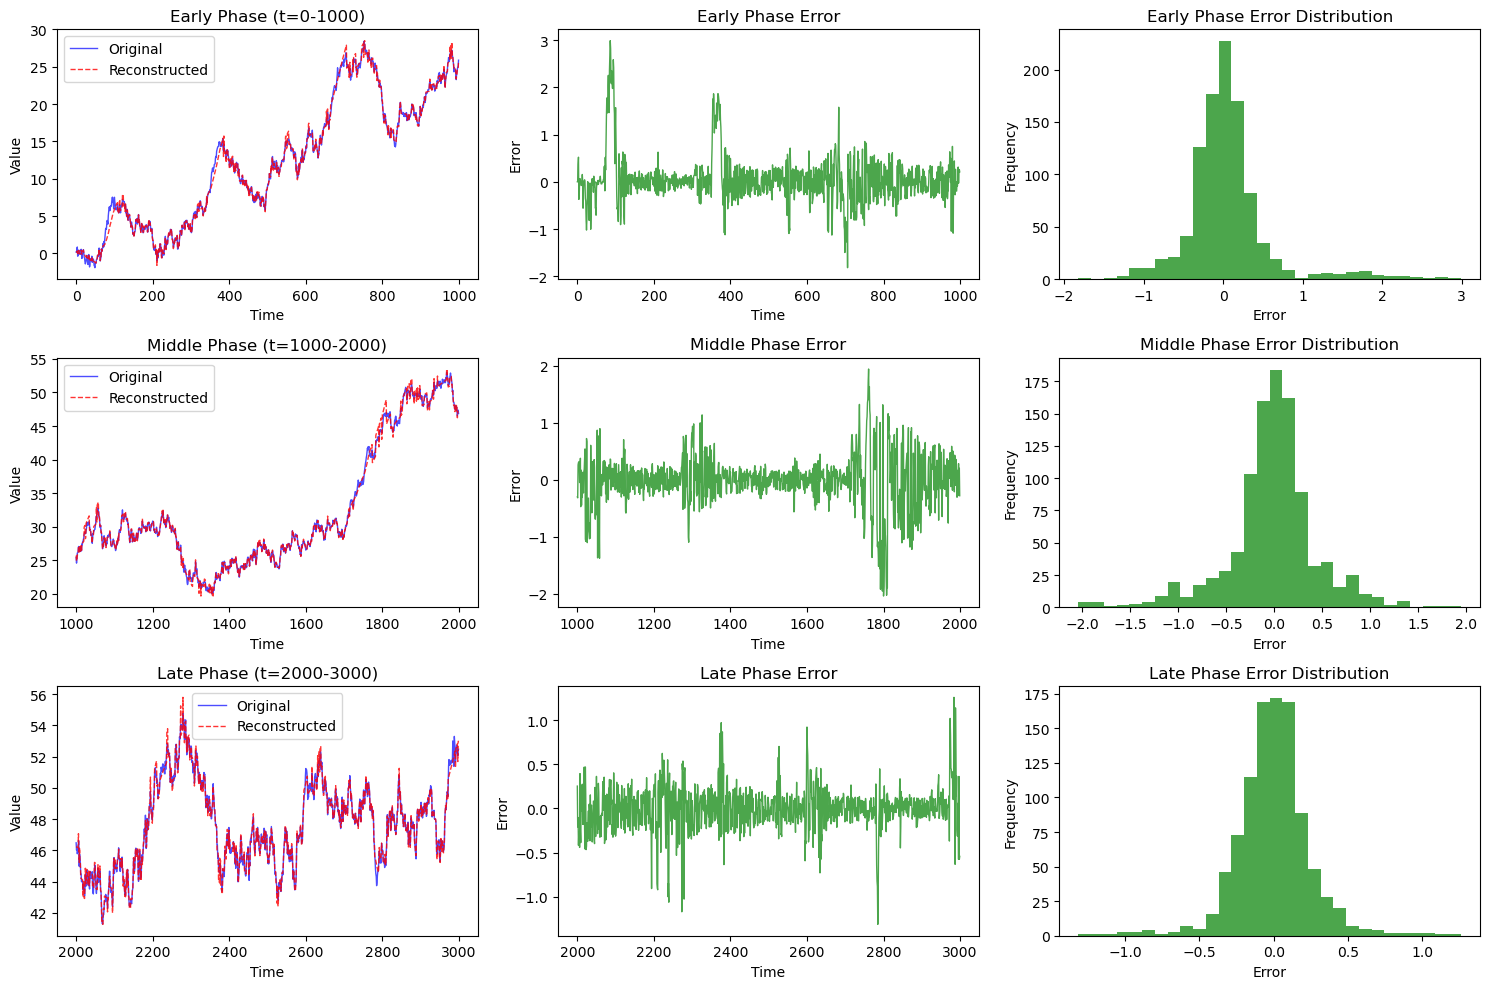

Reconstruction Quality Evolution:
  Early phase (t=0-1000):
    MSE: 0.271721
    RMSE: 0.521269
    Correlation: 0.9982
  Middle phase (t=1000-2000):
    MSE: 0.222983
    RMSE: 0.472211
    Correlation: 0.9987
  Late phase (t=2000-3000):
    MSE: 0.064674
    RMSE: 0.254310
    Correlation: 0.9957

Overall Statistics:
  Mean Squared Error: 0.143759
  Root Mean Squared Error: 0.379155
  Correlation (original vs reconstructed): 1.0000
  Vocabulary utilization: 16/16 tokens used


In [74]:
# np.random.seed(0)
T = 30_000
# generate a nonstationary series: random walk + drift + noise
x = (
    np.cumsum(np.random.randn(T) * 0.5)
    + 0.01 * np.arange(T)
    + 0.5 * np.sin(np.arange(T) / 50)
)

V = 16
tok = GQTokenizer(V)
tokens = np.empty(T, dtype=int)
x_reconstructed = np.empty(T)

means = np.empty(T)
stds = np.empty(T)

# Reconstructing as we go
for t in range(T):
    tok.update(x[t])
    tokens[t] = tok.encode(x[t])
    x_reconstructed[t] = tok.decode(tokens[t])

    means[t] = tok.stats.mean
    stds[t] = tok.stats.std

print("First 20 tokens:", tokens[:20])

# Track reconstruction quality over time
early_phase = slice(0, 1_000)      # First 10_000 points
middle_phase = slice(1_000, 2_000)  # Middle 1_000 points  
late_phase = slice(2_000, 3_000)    # Late 10_000 points

# Plot evolution of reconstruction quality
plt.figure(figsize=(15, 10))

# Early phase
plt.subplot(3, 3, 1)
plt.plot(np.arange(T)[early_phase], x[early_phase], 'b-', alpha=0.7, label='Original', linewidth=1)
plt.plot(np.arange(T)[early_phase], x_reconstructed[early_phase], 'r--', alpha=0.8, label='Reconstructed', linewidth=1)
plt.title(f"Early Phase (t={early_phase.start}-{early_phase.stop})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

plt.subplot(3, 3, 2)
early_error = x[early_phase] - x_reconstructed[early_phase]
plt.plot(np.arange(T)[early_phase], early_error, 'g-', alpha=0.7, linewidth=1)
plt.title("Early Phase Error")
plt.xlabel("Time")
plt.ylabel("Error")

plt.subplot(3, 3, 3)
plt.hist(early_error, bins=30, alpha=0.7, color='green')
plt.title("Early Phase Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")

# Middle phase
plt.subplot(3, 3, 4)
plt.plot(np.arange(T)[middle_phase], x[middle_phase], 'b-', alpha=0.7, label='Original', linewidth=1)
plt.plot(np.arange(T)[middle_phase], x_reconstructed[middle_phase], 'r--', alpha=0.8, label='Reconstructed', linewidth=1)
plt.title(f"Middle Phase (t={middle_phase.start}-{middle_phase.stop})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

plt.subplot(3, 3, 5)
middle_error = x[middle_phase] - x_reconstructed[middle_phase]
plt.plot(np.arange(T)[middle_phase], middle_error, 'g-', alpha=0.7, linewidth=1)
plt.title("Middle Phase Error")
plt.xlabel("Time")
plt.ylabel("Error")

plt.subplot(3, 3, 6)
plt.hist(middle_error, bins=30, alpha=0.7, color='green')
plt.title("Middle Phase Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")

# Late phase
plt.subplot(3, 3, 7)
plt.plot(np.arange(T)[late_phase], x[late_phase], 'b-', alpha=0.7, label='Original', linewidth=1)
plt.plot(np.arange(T)[late_phase], x_reconstructed[late_phase], 'r--', alpha=0.8, label='Reconstructed', linewidth=1)
plt.title(f"Late Phase (t={late_phase.start}-{late_phase.stop})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

plt.subplot(3, 3, 8)
late_error = x[late_phase] - x_reconstructed[late_phase]
plt.plot(np.arange(T)[late_phase], late_error, 'g-', alpha=0.7, linewidth=1)
plt.title("Late Phase Error")
plt.xlabel("Time")
plt.ylabel("Error")

plt.subplot(3, 3, 9)
plt.hist(late_error, bins=30, alpha=0.7, color='green')
plt.title("Late Phase Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print evolution statistics
print("Reconstruction Quality Evolution:")
print(f"  Early phase (t={early_phase.start}-{early_phase.stop}):")
print(f"    MSE: {np.mean(early_error**2):.6f}")
print(f"    RMSE: {np.sqrt(np.mean(early_error**2)):.6f}")
print(f"    Correlation: {np.corrcoef(x[early_phase], x_reconstructed[early_phase])[0,1]:.4f}")

print(f"  Middle phase (t={middle_phase.start}-{middle_phase.stop}):")
print(f"    MSE: {np.mean(middle_error**2):.6f}")
print(f"    RMSE: {np.sqrt(np.mean(middle_error**2)):.6f}")
print(f"    Correlation: {np.corrcoef(x[middle_phase], x_reconstructed[middle_phase])[0,1]:.4f}")

print(f"  Late phase (t={late_phase.start}-{late_phase.stop}):")
print(f"    MSE: {np.mean(late_error**2):.6f}")
print(f"    RMSE: {np.sqrt(np.mean(late_error**2)):.6f}")
print(f"    Correlation: {np.corrcoef(x[late_phase], x_reconstructed[late_phase])[0,1]:.4f}")

# Overall statistics
reconstruction_error = x - x_reconstructed
mse = np.mean(reconstruction_error**2)
print(f"\nOverall Statistics:")
print(f"  Mean Squared Error: {mse:.6f}")
print(f"  Root Mean Squared Error: {np.sqrt(mse):.6f}")
print(f"  Correlation (original vs reconstructed): {np.corrcoef(x, x_reconstructed)[0,1]:.4f}")
print(f"  Vocabulary utilization: {len(np.unique(tokens))}/{tok.V} tokens used")

## 2) Multivariate per-dimension binning + simple k-means codebook

In [75]:
#@title Neural Codebook: MLP + Embedding Table (replaces StreamingKMeans)

class NeuralCodebook(nn.Module):
    """
    Neural codebook that maps vector codes to embeddings via MLP + embedding table.
    
    Architecture:
    1. Input: vector code (D-dimensional integer vector)
    2. MLP: vector code -> logits (V_total)
    3. Sampling: logits -> token_id (straight-through estimator)
    4. Embedding: token_id -> embedding (D-dimensional)
    
    Training objective: MSE between embedding and decoded vector code
    """
    
    def __init__(self, D, V_total, hidden_dim=128, learning_rate=1e-3):
        super().__init__()
        self.D = D
        self.V_total = V_total
        self.learning_rate = learning_rate
        
        # MLP: input_dim=D, output_dim=V_total
        self.mlp = nn.Sequential(
            nn.Linear(D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, V_total)
        )
        
        # Embedding table: V_total embeddings of dimension D
        self.embedding_table = nn.Embedding(V_total, D)
        
        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # Training state
        self.training_step = 0
        
    def forward(self, vector_code):
        """
        Forward pass: vector_code -> token_id -> embedding
        
        Args:
            vector_code: [D] tensor of integers (vector code)
            
        Returns:
            token_id: scalar integer (sampled token)
            embedding: [D] tensor (selected embedding)
            logits: [V_total] tensor (for training)
        """
        # Convert to float for MLP
        vector_code_float = vector_code.float()
        
        # MLP: vector_code -> logits
        logits = self.mlp(vector_code_float)
        
        # Sampling: straight-through estimator
        # Forward: argmax (discrete)
        token_id = torch.argmax(logits, dim=-1)
        
        # Backward: use logits directly (continuous)
        if self.training:
            # During training, we need to handle the straight-through gradient
            # We'll do this in the training step
            pass
        
        # Get embedding
        embedding = self.embedding_table(token_id)
        
        return token_id, embedding, logits
    
    def train_step(self, vector_code, target_embedding):
        """
        Single training step with straight-through estimator.
        
        Args:
            vector_code: [D] tensor of integers
            target_embedding: [D] tensor (decoded vector code)
        """
        self.train()
        self.optimizer.zero_grad()
        
        # Forward pass
        vector_code_float = vector_code.float()
        logits = self.mlp(vector_code_float)
        
        # Straight-through estimator
        # Forward: discrete sampling
        token_id = torch.argmax(logits, dim=-1)
        embedding = self.embedding_table(token_id)
        
        # Loss: MSE between embedding and target
        loss = nn.functional.mse_loss(embedding, target_embedding)
        
        # Backward: use continuous logits for gradients
        # We need to compute gradients w.r.t. logits, then backprop through MLP
        loss.backward()
        
        # Update parameters
        self.optimizer.step()
        self.training_step += 1
        
        return loss.item(), token_id.item()
    
    def predict(self, vector_code):
        """Inference: get token_id for a vector code."""
        self.eval()
        with torch.no_grad():
            token_id, _, _ = self.forward(vector_code)
            return token_id.item()
    
    def get_embedding(self, token_id):
        """Get embedding for a token_id."""
        self.eval()
        with torch.no_grad():
            return self.embedding_table(torch.tensor(token_id)).cpu().numpy()


In [ ]:
class MultiGQTokenizer:
    """Multivariate Gaussian-Quantile tokenizer with neural codebook."""
    
    def __init__(self, D, V_uni=2, V_total=256, hidden_dim=128, learning_rate=1e-3):
        """
        Args:
            D: Number of dimensions
            V_uni: Vocabulary size per dimension (typically 2-4)
            V_total: Total vocabulary size (final tokens)
            hidden_dim: Hidden dimension for MLP
            learning_rate: Learning rate for neural codebook
        """
        self.D = D
        self.V_uni = V_uni
        self.V_total = V_total
        
        # Per-dimension tokenizers
        self.dim_tokenizers = [GQTokenizer(V_uni) for _ in range(D)]
        
        # Neural codebook
        self.codebook = NeuralCodebook(D, V_total, hidden_dim, learning_rate)
        
        # Training state
        self.training_step = 0
        
    def update(self, x):
        """Update tokenizer with new D-dimensional data point."""
        x = np.asarray(x)
        if x.shape != (self.D,):
            raise ValueError(f"Expected shape ({self.D},), got {x.shape}")
            
        # Skip update if entire vector is missing
        if np.all(np.isnan(x)):
            return
            
        # Update per-dimension tokenizers (only for valid dimensions)
        for d in range(self.D):
            if not np.isnan(x[d]):
                self.dim_tokenizers[d].update(x[d])
            
        # Get vector code and decoded target
        vector_code = self.encode_vector_code(x)
        target_embedding = self.decode_vector_code(vector_code)
        
        # Convert to tensors
        vector_code_tensor = torch.tensor(vector_code, dtype=torch.long)
        target_embedding_tensor = torch.tensor(target_embedding, dtype=torch.float32)
        
        # Train neural codebook
        loss, token_id = self.codebook.train_step(vector_code_tensor, target_embedding_tensor)
        self.training_step += 1
        
        # Optional: print training progress
        if self.training_step % 1000 == 0:
            print(f"Training step {self.training_step}, loss: {loss:.4f}")
            
    def encode_vector_code(self, x):
        """Encode to per-dimension codes (before codebook mapping)."""
        x = np.asarray(x)
        codes = np.empty(self.D, dtype=int)
        for d in range(self.D):
            codes[d] = self.dim_tokenizers[d].encode(x[d])
        return codes
    
    def decode_vector_code(self, codes):
        """Decode per-dimension codes back to real-valued quantized approximation."""
        codes = np.asarray(codes, dtype=int)
        quantized = np.empty(self.D)
        for d in range(self.D):
            decoded_val = self.dim_tokenizers[d].decode(codes[d])
            if np.isnan(decoded_val):
                # Handle missing values - use mean of the dimension if available
                if hasattr(self.dim_tokenizers[d].stats, 'mean') and self.dim_tokenizers[d].stats.mean is not None:
                    quantized[d] = self.dim_tokenizers[d].stats.mean
                else:
                    quantized[d] = 0.0  # Default fallback
            else:
                quantized[d] = decoded_val
        return quantized
        
    def encode(self, x):
        """Encode to final token ID."""
        x = np.asarray(x)
        
        # Return token 0 if entire vector is missing
        if np.all(np.isnan(x)):
            return 0
            
        # Get vector code
        vector_code = self.encode_vector_code(x)
        vector_code_tensor = torch.tensor(vector_code, dtype=torch.long)
        
        # Get token from neural codebook
        return self.codebook.predict(vector_code_tensor)
        
    def decode(self, token_id):
        """Decode token ID back to approximate original values."""
        # Token 0 represents missing values
        if token_id == 0:
            return np.full(self.D, np.nan)
            
        # Get embedding from neural codebook
        return self.codebook.get_embedding(token_id)


In [ ]:
# Neural Codebook Demo
print("Testing Neural Codebook Implementation...")

# Test parameters
D = 4
V_uni = 2
V_total = 16
T = 5000  # Shorter for demo

# Generate 4D correlated time series
np.random.seed(0)
cov = np.array([
    [1.0, 0.6, 0.0, 0.1],
    [0.6, 1.0, 0.2, 0.0],
    [0.0, 0.2, 1.0, 0.4],
    [0.1, 0.0, 0.4, 1.0],
])
L = np.linalg.cholesky(cov)
z = np.random.randn(T, D) @ L.T
X_mv = (np.cumsum(z, axis=0) * 0.1) + 0.1 * np.sin(np.arange(T)[:, None] / 30)

# Initialize neural tokenizer
neural_tok = MultiGQTokenizer(D, V_uni=V_uni, V_total=V_total, 
                                   hidden_dim=64, learning_rate=1e-3)

print(f"Training neural codebook on {T} samples...")
print("Progress updates every 1000 steps:")

# Train the neural codebook
for t in range(T):
    neural_tok.update(X_mv[t])

print(f"\nTraining completed! Total steps: {neural_tok.training_step}")

# Test encoding/decoding
print("\nTesting encoding/decoding...")
test_indices = [0, 1000, 2000, 3000, 4000]
for i in test_indices:
    original = X_mv[i]
    token = neural_tok.encode(original)
    reconstructed = neural_tok.decode(token)
    mse = np.mean((original - reconstructed)**2)
    print(f"Sample {i}: token={token}, MSE={mse:.4f}")

# Encode all data and compute reconstruction quality
print(f"\nEncoding all {T} samples...")
all_tokens = np.array([neural_tok.encode(x) for x in X_mv], dtype=int)
all_reconstructed = np.stack([neural_tok.decode(tok) for tok in all_tokens], axis=0)

# Compute overall reconstruction quality
overall_mse = np.mean((X_mv - all_reconstructed)**2)
print(f"Overall MSE: {overall_mse:.4f}")

# Vocabulary utilization
unique_tokens = len(np.unique(all_tokens))
print(f"Vocabulary utilization: {unique_tokens}/{V_total} tokens used")

# Per-dimension correlation
print("\nPer-dimension reconstruction quality:")
for d in range(D):
    corr = np.corrcoef(X_mv[:, d], all_reconstructed[:, d])[0, 1]
    mse_d = np.mean((X_mv[:, d] - all_reconstructed[:, d])**2)
    print(f"Dim {d}: correlation={corr:.4f}, MSE={mse_d:.4f}")


Testing Neural Codebook Implementation...
Training neural codebook on 5000 samples...
Progress updates every 1000 steps:
Training step 1000, loss: 11.0070
Training step 2000, loss: 4.3076
Training step 3000, loss: 8.0559
Training step 4000, loss: 0.9321
Training step 5000, loss: 4.7946

Training completed! Total steps: 5000

Testing encoding/decoding...
Sample 0: token=14, MSE=13.9766
Sample 1000: token=14, MSE=3.0442
Sample 2000: token=14, MSE=2.1612
Sample 3000: token=14, MSE=6.6333
Sample 4000: token=14, MSE=1.2908

Encoding all 5000 samples...
Overall MSE: 4.8802
Vocabulary utilization: 1/16 tokens used

Per-dimension reconstruction quality:
Dim 0: correlation=nan, MSE=4.9034
Dim 1: correlation=nan, MSE=4.9568
Dim 2: correlation=nan, MSE=3.5286
Dim 3: correlation=nan, MSE=6.1321


/Users/quileesimeon/miniforge3/envs/work_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/quileesimeon/miniforge3/envs/work_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


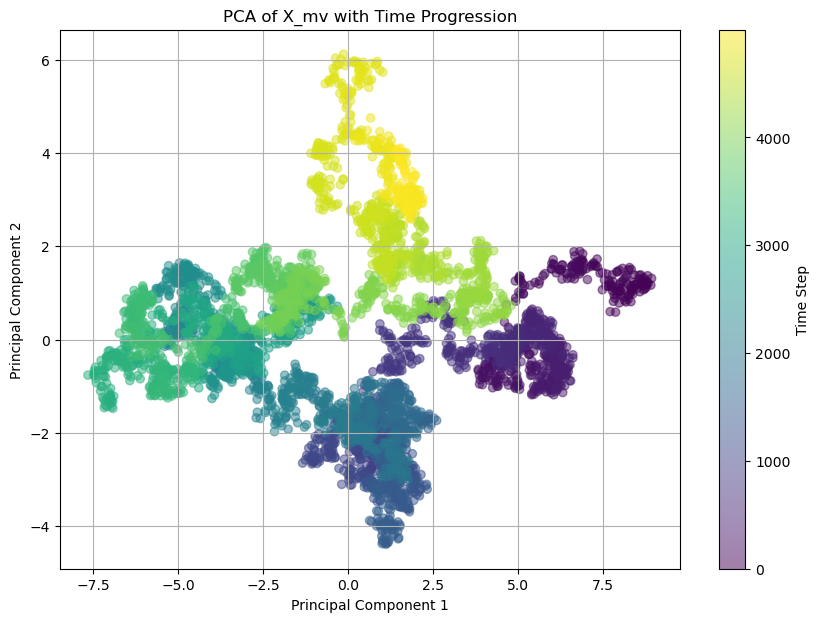

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_mv)

# Plot the PCA results with a sequential colormap
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(len(X_pca)), cmap='viridis', alpha=0.5)
plt.title('PCA of X_mv with Time Progression')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Time Step')
plt.grid(True)
plt.show()

